# Plot performance over clauses

For each clause, plot three performance: ID, OOD, prompting.

The performance is averaged over three splits.

## Data Loading and Processing

In [1]:
import json
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from typing import List

fpath = Path(mpl.get_data_path(), "/storage_fast/rhshui/resource/arial-font/arial.ttf")
def set_texts_font(texts, f_name, f_size):
    for text in texts:
        text.set_font(f_name)
        text.set_fontsize(f_size)

In [2]:
pfm_ood = pd.read_pickle('save_data/best_ood.pkl')
pfm_all = pd.read_pickle('save_data/best_alllab.pkl')
pfm_zs = pd.read_pickle('save_data/zs_baseline.pkl')

In [3]:
pfm_zs.columns

Index(['model', 'split', 'res_ov', 'res_detail'], dtype='object')

In [4]:
"""
Merge the performance of different splits.

Output: must contain model, res_ov, res_detail
"""
def merge_dict(dict_list):
    """Several dict with same keys. Get the average of the values"""
    keys = list(dict_list[0].keys())
    array = [[d[k] for k in d] for d in dict_list]
    array_T = list(zip(*array)) # transpose
    ave_array = [np.mean(k) for k in array_T]
    return dict(zip(keys, ave_array))

def merge_df(df_list: List[pd.DataFrame]):
    """get the average metrics of q_id"""
    # first, get the q_id to metrics
    q2met_list = {}
    for df in df_list:
        for _, row in df.iterrows():
            qid = int(row['q_id'])
            if qid not in q2met_list:
                q2met_list[qid] = []
            q2met_list[qid].append(row.iloc[1:].to_dict())
    # Average merge
    q2met = {q:merge_dict(ml) for q, ml in q2met_list.items()}

    # Take the first
    # q2met = {q:ml[0] for q, ml in q2met_list.items()}
    return q2met
    
def merge_splits(pfm_df: pd.DataFrame):
    lines = []
    for model, part_df in pfm_df.groupby('model'):
        res_ov = merge_dict(part_df['res_ov'].to_list())
        res_detail = merge_df(part_df['res_detail'].to_list())
        lines.append((model, res_ov, res_detail))
    return pd.DataFrame(lines, columns = ['model', 'res_ov', 'res_detail'])

In [5]:
merge_pfm_ood = merge_splits(pfm_ood)
merge_pfm_all = merge_splits(pfm_all)
merge_pfm_zs = merge_splits(pfm_zs)

In [6]:
merge_pfm_all.head()

,model,res_ov,res_detail
0,flan-t5-xl,"{'doc_macro_f1': 0.901811812172118, 'doc_macro...","{1: {'macro_p': 0.7639817310913313, 'macro_r':..."
1,llama3,"{'doc_macro_f1': 0.8676106496288964, 'doc_macr...","{1: {'macro_p': 0.7184442618460696, 'macro_r':..."
2,llama3_chat,"{'doc_macro_f1': 0.8699637829962698, 'doc_macr...","{1: {'macro_p': 0.6578508771929824, 'macro_r':..."
3,mistral,"{'doc_macro_f1': 0.8815248400386397, 'doc_macr...","{1: {'macro_p': 0.680527608206329, 'macro_r': ..."
4,mistral_chat,"{'doc_macro_f1': 0.8484591838157197, 'doc_macr...","{1: {'macro_p': 0.5528528921253807, 'macro_r':..."


In [7]:
# Check the result is same as the main table
print(merge_pfm_ood.iloc[0]['model'])
merge_pfm_ood.iloc[0]['res_ov']

flan-t5-large


{'doc_macro_f1': 0.8034396248261274,
 'doc_macro_iou': 0.7857855319868978,
 'doc_macro_p': 0.8787147354452022,
 'doc_macro_r': 0.8758632493636725,
 'macro_f1': 0.4599407520723104,
 'macro_iou': 0.3325544554544686,
 'macro_p': 0.6769189428000421,
 'macro_r': 0.4736945354428055,
 'micro_f1': 0.512166308993747,
 'micro_iou': 0.34423808747681006,
 'micro_p': 0.6318506820590942,
 'micro_r': 0.45751047247693544}

### Only keep the macro_iou metric

In [8]:
def get_model_metric(df, model, metric):
    """Return clause metric of the model, sort by clause id"""
    cla_mets = df[df['model'] == model].iloc[0]['res_detail']
    cla_met = {k:v[metric] for k,v in cla_mets.items()}
    its = list(cla_met.items())
    its.sort(key = lambda k: k[0])
    return list(zip(*its))

In [9]:
cids1, llama3_iou_zs = get_model_metric(merge_pfm_zs, 'llama3_chat', 'macro_iou')
cids2, llama3_iou_all = get_model_metric(merge_pfm_all, 'llama3_chat', 'macro_iou')
cids3, llama3_iou_ood = get_model_metric(merge_pfm_ood, 'llama3_chat', 'macro_iou')
cids3, llama3_iou_ood2 = get_model_metric(merge_pfm_ood, 'llama3', 'macro_iou')

_, flanxl_iou_zs = get_model_metric(merge_pfm_zs, 'flan-t5-xl', 'macro_iou')
_, flanxl_iou_all = get_model_metric(merge_pfm_all, 'flan-t5-xl', 'macro_iou')
_, flanxl_iou_ood = get_model_metric(merge_pfm_ood, 'flan-t5-xl', 'macro_iou')
assert cids1 == cids2
assert cids1 == cids3

In [17]:
model_ood_maiou = {m: get_model_metric(merge_pfm_ood, m, 'macro_iou')[1] 
                    for m in ['llama3', 'llama3_chat', 'flan-t5-xl', 'mistral', 'mistral_chat']}
model_all_maiou = {m: get_model_metric(merge_pfm_all, m, 'macro_iou')[1] 
                    for m in ['llama3', 'llama3_chat', 'flan-t5-xl', 'mistral', 'mistral_chat']}

### Plot

In [10]:
# Get clause name
cla_info = pd.read_csv('/storage/rhshui/workspace/contract_review/data/clause/all_info.csv')
id2cname = {i: row['clause_type'] for i, row in cla_info.iterrows()}

y_labels = [id2cname[i] for i in cids1]
# Filter label names
abbrev = {'Notice Period To Terminate Renewal': 'Notice Period To Term.',
          'Irrevocable Or Perpetual License': 'Irrevocable Or .. License',
          'Termination For Convenience': 'Term. For Convenience'  
          }
y_labels = [abbrev.get(k, k) for k in y_labels]

In [27]:
def plot_clause_bar(y_zs, y_all, y_ood, y_labels):
    # Sort the values
    rank_id = np.argsort(y_ood)[-17:]
    y_zs = [y_zs[i] for i in rank_id]
    y_all = [y_all[i] for i in rank_id]
    y_ood = [y_ood[i] for i in rank_id]
    y_labels = [y_labels[i] for i in rank_id]

    fig = plt.figure(figsize=(4,6))
    ax = plt.subplot()
    bar_w = 0.25
    y_ticks = np.arange(len(y_zs))
    bar_1 = ax.barh(y_ticks, list(y_zs), height = bar_w, label = 'Prompting')
    bar_2 = ax.barh(y_ticks + bar_w, list(y_ood), height = bar_w, label = 'OOD')
    bar_3 = ax.barh(y_ticks + bar_w*2, list(y_all), height = bar_w, label = 'Full')
    ytick_obj = ax.set_yticks(y_ticks+bar_w, y_labels)
    lgd = plt.legend((bar_3, bar_2, bar_1), ['Full', 'OOD', 'Prompting'])

    ax.set_ylim(-0.2, y_ticks[-1] + 1)

    set_texts_font(ax.get_yticklabels(), fpath, 13)
    set_texts_font(ax.get_xticklabels(), fpath, 12)
    set_texts_font(lgd.texts, fpath, 11)


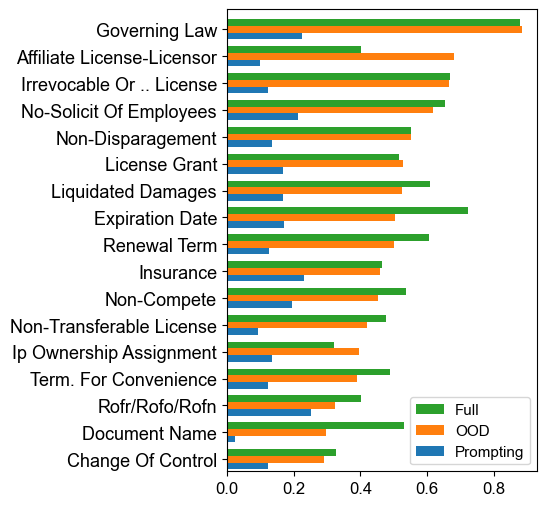

In [28]:
# plot the bar
plot_clause_bar(llama3_iou_zs, llama3_iou_all, llama3_iou_ood, y_labels)
plt.savefig('./fig/fig_clause_pfm_llama3_chat.pdf', bbox_inches='tight')

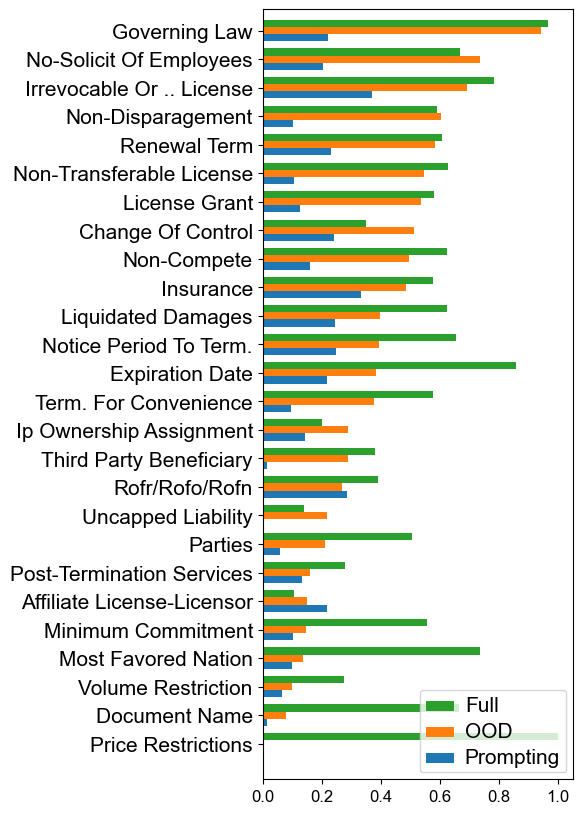

In [142]:
plot_clause_bar(flanxl_iou_zs, flanxl_iou_all, flanxl_iou_ood, y_labels)

### Decrease of recall for training on full label

In [107]:
merge_pfm_all[merge_pfm_all['model'] == 'flan-t5-xl'].iloc[0]['res_detail'][17]

{'macro_p': 0.953931691818904,
 'macro_r': 0.3556411015694403,
 'macro_f1': 0.5181190681622088,
 'macro_iou': 0.3496360989810771,
 'doc_macro_p': 0.9696428843487668,
 'doc_macro_r': 0.8452927055140268,
 'doc_macro_f1': 0.842493574204996,
 'doc_macro_iou': 0.8323633177360388}

In [108]:
merge_pfm_ood[merge_pfm_ood['model'] == 'flan-t5-xl'].iloc[0]['res_detail'][17]

{'macro_p': 0.7990334273056786,
 'macro_r': 0.5875037015102161,
 'macro_f1': 0.6771331058020478,
 'macro_iou': 0.5118679050567595,
 'doc_macro_p': 0.9365432383615984,
 'doc_macro_r': 0.9083790037589364,
 'doc_macro_f1': 0.886344799308989,
 'doc_macro_iou': 0.8644357008676723}

## Plot correlation

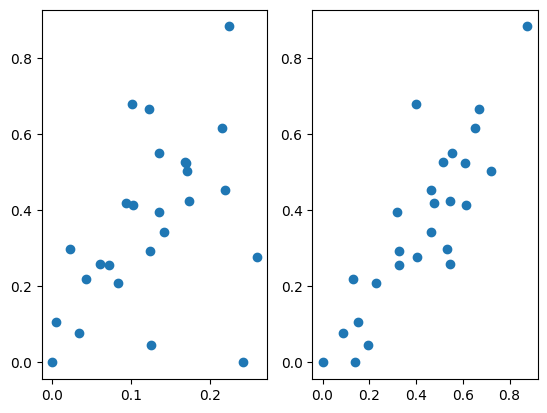

In [90]:
y_zs = llama3_iou_zs
y_all = llama3_iou_all
y_ood = llama3_iou_ood

fig, axes = plt.subplots(1, 2)
axes[0].scatter(y_zs, y_ood)
axes[1].scatter(y_all, y_ood)

In [105]:
print(np.corrcoef(llama3_iou_zs, llama3_iou_ood))
print(np.corrcoef(llama3_iou_all, llama3_iou_ood))

[[1.         0.58126857]
 [0.58126857 1.        ]]
[[1.         0.87697478]
 [0.87697478 1.        ]]


In [106]:
print(np.corrcoef(flanxl_iou_zs, flanxl_iou_ood))
print(np.corrcoef(flanxl_iou_all, flanxl_iou_ood))

[[1.         0.56030194]
 [0.56030194 1.        ]]
[[1.         0.37354384]
 [0.37354384 1.        ]]


In [18]:
for m in ['flan-t5-xl', 'llama3', 'llama3_chat', 'mistral', 'mistral_chat']:
    corr = np.corrcoef(model_ood_maiou[m], model_all_maiou[m])[0][1]
    print(f'{m}: {corr:.4f}')

flan-t5-xl: 0.3735
llama3: 0.8327
llama3_chat: 0.8770
mistral: 0.7061
mistral_chat: 0.8818


In [74]:
id2cname

{0: 'Document Name',
 1: 'Parties',
 2: 'Agreement Date',
 3: 'Effective Date',
 4: 'Expiration Date',
 5: 'Renewal Term',
 6: 'Notice Period To Terminate Renewal',
 7: 'Governing Law',
 8: 'Most Favored Nation',
 9: 'Non-Compete',
 10: 'Exclusivity',
 11: 'No-Solicit Of Customers',
 12: 'Competitive Restriction Exception',
 13: 'No-Solicit Of Employees',
 14: 'Non-Disparagement',
 15: 'Termination For Convenience',
 16: 'Rofr/Rofo/Rofn',
 17: 'Change Of Control',
 18: 'Anti-Assignment',
 19: 'Revenue/Profit Sharing',
 20: 'Price Restrictions',
 21: 'Minimum Commitment',
 22: 'Volume Restriction',
 23: 'Ip Ownership Assignment',
 24: 'Joint Ip Ownership',
 25: 'License Grant',
 26: 'Non-Transferable License',
 27: 'Affiliate License-Licensor',
 28: 'Affiliate License-Licensee',
 29: 'Unlimited/All-You-Can-Eat-License',
 30: 'Irrevocable Or Perpetual License',
 31: 'Source Code Escrow',
 32: 'Post-Termination Services',
 33: 'Audit Rights',
 34: 'Uncapped Liability',
 35: 'Cap On Liabil